In [1]:
import pandas as pd
from hkfold import HKFold
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from keras.layers import PReLU
from sklearn.utils import shuffle
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from keras.models import load_model
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [37]:
dframe_path = 'data/cabauw/processed.csv.gz'

try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')


df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
df = df[df.ds != 201603]
df = df.dropna()
df = df[df.z > 10]

In [87]:
features = [
    'dewpoint', 'spec_hum', 'press', 'temp', 'air_dens', 
    'virtual_temp', 'rel_hum', 'rain', 'soil_temp',
    'H', 'LE',
    'z',
    'wind',
    'zL', 
    'lval',
    'ustar', 
]

target = 'phi_m'

test_ds = np.random.choice(df.ds.unique(), 12, replace=False)
test_mask = df.ds.isin(test_ds)
train_x, train_y = df[~test_mask][features], df[~test_mask][target]
test_x, test_y = df[test_mask][features], df[test_mask][target]
train_x, train_y = shuffle(train_x, train_y)

print('training with %d, testing with %d' % (len(train_x), len(test_x)))

training with 823284, testing with 63444


In [88]:
mean_x, mean_y = train_x.mean(), train_y.mean()
std_x, std_y = train_x.std(), train_y.std()

norm_train_x = (train_x - mean_x) /  std_x
norm_test_x = (test_x - mean_x) / std_x

norm_train_y = (train_y - mean_y) / std_y
norm_test_y = (test_y - mean_y) / std_y

In [92]:
model = Sequential([
    Dense(1024, input_shape=(len(features),)), PReLU(),
    Dropout(0.5),
    Dense(256), PReLU(),
    Dense(128), PReLU(),
    Dense(32), PReLU(),
    Dense(1)
])

opt = RMSprop(lr=0.001)
model.compile(loss='mse', optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 1024)              17408     
_________________________________________________________________
p_re_lu_95 (PReLU)           (None, 1024)              1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_119 (Dense)            (None, 256)               262400    
_________________________________________________________________
p_re_lu_96 (PReLU)           (None, 256)               256       
_________________________________________________________________
dense_120 (Dense)            (None, 128)               32896     
_________________________________________________________________
p_re_lu_97 (PReLU)           (None, 128)               128       
__________

In [93]:
hist = model.fit(
    norm_train_x, norm_train_y,
    batch_size=2048, epochs=250,
    shuffle=True,
    callbacks=[
        ReduceLROnPlateau(factor=0.2, verbose=1, min_lr=1e-6),
        ModelCheckpoint('dev/models/weights-w.{epoch:04d}-{val_loss:.4f}.hdf5',
                        verbose=1, save_best_only=True),
        TensorBoard('dev/logs/', write_graph=False, write_grads=True),
        EarlyStopping(min_delta=0.0001, patience=30),
    ],
    validation_data=(norm_test_x, norm_test_y)
)

Train on 823284 samples, validate on 63444 samples
Epoch 1/250
817152/823284 [============================>.] - ETA: 0s - loss: 0.1856
Epoch 00001: val_loss improved from inf to 0.16652, saving model to dev/models/weights-w.0001-0.1665.hdf5
823284/823284 [==============================] - 15s 18us/step - loss: 0.1853 - val_loss: 0.1665
Epoch 2/250
819200/823284 [============================>.] - ETA: 0s - loss: 0.1515
Epoch 00002: val_loss improved from 0.16652 to 0.12760, saving model to dev/models/weights-w.0002-0.1276.hdf5
823284/823284 [==============================] - 10s 12us/step - loss: 0.1515 - val_loss: 0.1276
Epoch 3/250
819200/823284 [============================>.] - ETA: 0s - loss: 0.1423
Epoch 00003: val_loss did not improve
823284/823284 [==============================] - 9s 11us/step - loss: 0.1423 - val_loss: 0.1723
Epoch 4/250
819200/823284 [============================>.] - ETA: 0s - loss: 0.1349
Epoch 00004: val_loss did not improve
823284/823284 [================

In [59]:
def plot_preds(ypred, ytrue):
    minn = max(min(ypred), min(ytrue))
    maxx = min(max(ypred), max(ytrue))
    
    plt.scatter(ytrue, ypred, s=2)
    plt.plot([minn, maxx], [minn, maxx], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    
    plt.show()

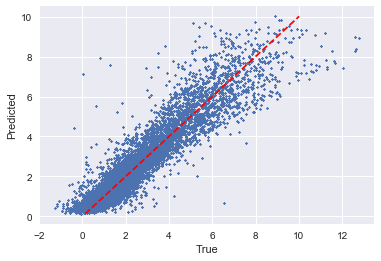

Explained variance 0.8711198015330996
Mean absolute error 0.43046116433517867
Mean squared error 0.43789031325265876
Median absolute error 0.28402285193515076
R2 score 0.8704058092112739
Mean absolute percent error [66.71847]


In [91]:
best_model = load_model('dev/models/weights-w.0008-0.1295.hdf5')
y_pred = best_model.predict(norm_test_x)

# denormalize
test_deno = norm_test_y * std_y + mean_y
pred_deno = y_pred * std_y + mean_y

plot_preds(pred_deno, test_deno)

print('Explained variance', metrics.explained_variance_score(test_deno, pred_deno))
print('Mean absolute error', metrics.mean_absolute_error(test_deno, pred_deno))
print('Mean squared error', metrics.mean_squared_error(test_deno, pred_deno))
print('Median absolute error', metrics.median_absolute_error(test_deno, pred_deno))
print('R2 score', metrics.r2_score(test_deno, pred_deno))
mape = 100 * sum(abs((yt - yp) / yt) for yt, yp in zip(test_deno, pred_deno)) / len(test_deno)
print('Mean absolute percent error', mape)